In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dss
import opendssdirect

In [94]:
engine = dss.DSS
engine.Start(0)
engine.ClearAll()
print(engine.DataPath)


/home/ubuntu/jwcha/opendss_option_python/tutorials/


In [95]:
engine.Text.Command = "compile Example1.dss"
engine.ActiveCircuit.Solution.Solve()

In [80]:
engine.ActiveCircuit.AllBusDistances

array([0., 0., 0., 0., 0., 0.])

In [83]:
engine.ActiveCircuit.ActiveBus.Nodes

array([1, 2, 3], dtype=int32)

In [86]:
engine.ActiveCircuit.LineGeometries.AllNames

['NONE']

In [88]:
engine.ActiveCircuit.Generators.AllNames

['gen1']

In [90]:
engine.ActiveCircuit.Loads.AllNames

['load1', 'load2']

In [96]:
engine.ActiveCircuit.Solution.Time_of_Step

0.0

In [97]:
engine.ActiveCircuit.Solution.Algorithm

0

In [98]:
engine.ActiveCircuit.Solution.dblHour

0.0

In [99]:
engine.ActiveCircuit.Solution.Year

0

In [ ]:
engine.ActiveCircuit.

In [66]:
engine = dss.DSS
engine.ClearAll()
engine.Text.Command = "compile ~/jwcha/opendss_option_python/iowa_test_system/Master.dss"
print("engine.ActiveCircuit.Solution.InitSnap()", engine.ActiveCircuit.Solution.InitSnap())
print("engine.ActiveCircuit.Solution.Mode",       engine.ActiveCircuit.Solution.Mode)
print("engine.ActiveCircuit.Solution.Number",     engine.ActiveCircuit.Solution.Number)
print("engine.ActiveCircuit.Solution.dblHour",    engine.ActiveCircuit.Solution.dblHour)

engine.ActiveCircuit.Solution.InitSnap() None
engine.ActiveCircuit.Solution.Mode 0
engine.ActiveCircuit.Solution.Number 100
engine.ActiveCircuit.Solution.dblHour 0.0


In [67]:
print(engine.ActiveCircuit.Solution.SolveNoControl())

None


In [62]:
from numpy import *
from pylab import *
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ColorConverter
import matplotlib.text as text
colorConverter = ColorConverter()
import re

class DSSModel:
# """
# tshort@epri.com 2008-11-17
# comments: wsunderman@epri.com 2009-10-30


    def __init__(self, filename = ""):
        """
        Inputs:
            filename - string - DSS input file
        Side effects:
            start DSS via COM
        Contains the following DSS COM objects:
            engine
            text
            circuit
        """
# start an embedded DSS engine through COM
# note: OpenDSSEngine.dll must already be registered
        self.engine = dss.DSS
        self.engine.ClearAll()
        self.engine.Start(0)


# use the Text interface to OpenDSS
        self.text = self.engine.Text
        self.text.Command = "clear"
        self.circuit = self.engine.ActiveCircuit

        print(self.engine.Version)


# if filename is not empty, then compile the .dss file specified
# note:  filename includes the path and the .dss file name
# note:  the .dss file compiled is usually the master.dss file
# note:  an energymeter should be defined at the head of the circuit
# being modeled
# note:  if compilation is successful we have a circuit instance
# that represents the electric circuit that is being modeled
        if filename != "":
            self.text.Command = "compile [" + filename + "]"
            # self.text.Command = "New EnergyMeter.Feeder Line.L115 1"
            self.text.Command = "solve"
            self.text.Command = "Buscoords Buscoords.dss"   # load in bus coordinates
            self.populate_results()


# method gets the bus and branch names of the DSS 'circuit' instance
# also populates the branch currents and bus voltages
    def populate_results(self):
        self.bus = Bus(self.circuit)
        self.branch = Branch(self.circuit)

# method plots the voltages and map in separate windows
# and shows them
    def plots(self):
        self.plot_voltage()
        self.plot_map()
        show()


# method displays (prints) line name, number of phases,
# voltages in actual volts and volts on a 120V basis,
# displays currents, and calculates real power, reactive
# power, and pf (displacement)
# in a text window
    def print_branch_info(self, event):
        ind = event.ind[0]
        print(" ")
        print("line: ", self.branch.name[ind])
        print("number of phases: ", self.branch.nphases[ind])
        print("voltages: ", around(abs(self.branch.Vto[ind]), 1))
        print("voltages (120-V base): ", around(abs(self.branch.Vto[ind]) / self.branch.kvbase[ind] * 120 / 1000, 1))

        print("currents: ", around(abs(self.branch.I[ind])))
        S = self.branch.V[ind] * self.branch.I[ind].conj()
        print("kilowatts: ", around(S.real / 1000))
        print("kilovars: ", around(S.imag / 1000))
        print("pf: ", around(S.real / abs(S), 2))

        print(" ")

# method does the plotting of the voltages on a 120V base versus distance
# x = distance
# y = voltage (120V base)
    def plot_voltage(self):
        fig = figure()
        def t(x): return x.transpose()

#scale factor gets us to 120V from the kvbase which is set in the .dss file
        scalefactor = 1 / self.branch.kvbase * 120 / 1000

        x = self.branch.distance
        y = t(t(abs(self.branch.Vto)) * scalefactor)
        plot(x, y, '*', markersize=5, picker=5)

#       # the following code will scale the size dot by the number of phases
#       # it's nice, but it makes the code slow
#         size = (self.branch.nphases + 1) ** 2
#         scatter(self.branch.distance, abs(self.branch.Vto[:,0]), s = size, c = 'r', picker=5)
#         scatter(self.branch.distance, abs(self.branch.Vto[:,1]), s = size, c = 'g', picker=5)
#         scatter(self.branch.distance, abs(self.branch.Vto[:,2]), s = size, c = 'b', picker=5)

# setup the pick events to highlight the voltage plot, circuit map,
# and to display the branch info in the text box
# note:  a pick event is usually a mouse click within a certain radius
# of the actual points on the plots
# note:  all three methods get called on any pick event
        connect('pick_event', self.highlight_voltage_plot)
        connect('pick_event', self.highlight_map)
        connect('pick_event', self.print_branch_info)

        self.fig = fig
        self.selected, = plot(x[0:3], y[0], 'o', ms=12, alpha=0.7,
            color='yellow', visible=False)

        ax = fig.add_subplot(111)
        ax.set_xticklabels([])
        ax.set_xlabel('distance')
        ax.set_ylabel('Voltage (120V base)')
        ax.set_title('Primary Voltages by phase')
        for o in fig.findobj(text.Text):
            o.set_fontsize(18)

# set the limits (x and y) of the plot to contain all of the points
        #xlim(x[x > 0].min(), x.max())
        #ylim(y[y > 0].min(), y.max())

# method highlights the voltage plot based on
# the x and y coordinates of the pick event (mouse click)
    def highlight_voltage_plot(self, event):
        axis = event.artist.get_axes()
        ind = event.ind[0]
        x = self.branch.distance[ind].repeat(3)
        y = abs(self.branch.Vto[ind]) / self.branch.kvbase[ind] * 120 / 1000
        self.selected.set_visible(True)
        self.selected.set_data(x, y)
        self.fig.canvas.draw()

# method does the plotting of the map of the circuit
# note:  master file should have the following text in it
# Buscoords buscoords.dss, where buscoords.dss contains the x and y
# coordinates for each bus to be plotted
    def plot_map(self):
        fig = figure()

# get x and y coordinates of the branch to be drawn
# the branch is a line so it is defined with pairs of
# from and to coordinates
        x1 = self.branch.x
        y1 = self.branch.y
        x2 = self.branch.xto
        y2 = self.branch.yto
        axes().set_aspect('equal', 'datalim')

# don't want to see any ticks on the x-axis or the y-axis
        xticks([])
        yticks([])

# set the limits of the map plot
        xlim(x1.min(), x1.max())
        ylim(y1.min(), y1.max())

# take the from x and y coordinates and the to x and y coordinates
# and put them together (zip) as a python sequence object
        segments = [ ( (thisx1, thisy1), (thisx2, thisy2) )  for thisx1, thisy1, thisx2, thisy2 in zip(x1,y1,x2,y2)]

# make a LineCollection of the segments, with width indicating the number
# of phases
        line_segments = LineCollection(segments,
                                       linewidths    = self.branch.nphases*1.5,
                                       linestyle = 'solid', picker = 5)
        gca().add_collection(line_segments)

# setup the pick events to highlight the voltage plot, circuit map,
# and to display the branch info in the text box
# note:  a pick event is usually a mouse click within a certain radius
# of the actual points on the plots
        connect('pick_event', self.highlight_voltage_plot)
        connect('pick_event', self.highlight_map)
        connect('pick_event', self.print_branch_info)
        self.mapfig = fig
# plot a yellow circle at the 'to' bus of the line segment if clicked on with
# the mouse
        self.mapselected,  = plot([x2[0]], [y2[0]], 'o', ms=12, alpha=0.4, color='yellow', visible=False)


# method highlights the map plot based on
# the x and y coordinates of the pick event (mouse click)
    def highlight_map(self, event):
        axis = event.artist.get_axes()
        ind = event.ind[0]
        x = self.branch.x[ind]
        y = self.branch.y[ind]
        xto = self.branch.xto[ind]
        yto = self.branch.yto[ind]
        self.mapselected.set_visible(True)
        self.mapselected.set_data(xto,yto)
        self.mapfig.canvas.draw()

engine = dss.DSS
engine.ClearAll()
model = DSSModel("iowa_power_system/Master.dss")

DSS C-API Library version 0.10.7-1 revision 8c84127a0c59289d09c1399a9759e243da273b78 based on OpenDSS SVN 2988 (v7/classic variation) MVMULT [FPC 3.2.0] (64-bit build); License Status: Open 


DSSException: (243, 'Redirect File: "/home/ubuntu/jwcha/opendss_option_python/ieee123/iowa_power_system/Master.dss" Not Found.')

IndexError: index 0 is out of bounds for axis 0 with size 0

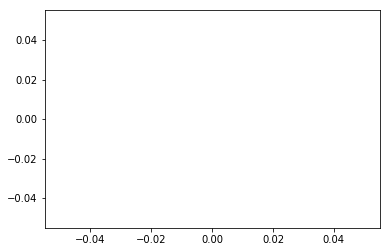

In [60]:
%matplotlib inline
model.plots()

In [44]:
# the Bus class uses the circuit instance from the DSS COM object
# and gets the names, bus voltages, distances from the energy meter,
# x and y coordinates of the 'from' bus and puts them into numpy arrays
class Bus:
    def __init__(self, circuit):
        """
        Inputs:
            circuit - DSS COM object
        Contains:
            name - string - bus name
            V - complex array (n x 3) - node bus voltage
            distance - array (n) - distance from the energymeter
            x - array (n) - from-bus x location
            y - array (n) - from-bus y location
        """
# n is set to the number of buses in the circuit
        n = circuit.NumBuses

# make the x,y, distance, and voltage numpy arrays of length n and set
# the vslues to all zeros
# note:  the voltage array is an array of complex values
        x = zeros(n)
        y = zeros(n)
        distance = zeros(n)
        V = zeros((n,3), dtype=complex)
        name = array("                                ").repeat(n)

# populate the arrays by looking at the each bus in turn from 0 to n
# note:  by convention all arrays are zero-based in python
        for i in range(0,n):
            bus = circuit.Buses(i)
            name[i] = bus.Name
            x[i] = bus.x
            y[i] = bus.y
            distance[i] = bus.Distance
            v = array(bus.Voltages)
            nodes = array(bus.Nodes)

# we're only interested in the first three nodes
# (also called terminals) on the bus
            if nodes.size > 3: nodes = nodes[0:3]
            cidx = 2 * array(range(0, int(min(v.size / 2, 3))))
            V[i, nodes-1] = v[cidx] + 1j * v[cidx + 1]
        self.name = name
        self.V = V
        self.x = x
        self.y = y
        self.distance = distance

# Branch class contains the branch object details
class Branch:
    def __init__(self, circuit):
        """
        Inputs:
            circuit - DSS COM object
        Contains:
            name - string - branch name
            busname - string (n) - from-node bus name
            busnameto - string (n) - to-node bus name
            V - complex array (n x 3) - from-node bus voltage
            Vto - complex array (n x 3) - to-node bus voltage
            I - complex array (n x 3) - branch currents
            nphases - array (n) - number of phases
            distance - array (n) - distance from the energy meter
            x - array (n) - from-bus x location
            y - array (n) - from-bus y location
            xto - array (n) - to-bus x location
            yto - array (n) - to-bus y location
        """
        n = circuit.NumCktElements
        name = array("                      ").repeat(n)
        busname = array("                      ").repeat(n)
        busnameto = array("                      ").repeat(n)
        x = zeros(n)
        y = zeros(n)
        xto = zeros(n)
        yto = zeros(n)
        distance = zeros(n)
        nphases = zeros(n)
        kvbase = zeros(n)
        I = zeros((n,3), dtype=complex)
        V = zeros((n,3), dtype=complex)
        Vto = zeros((n,3), dtype=complex)
        i = 0
        for j in range(0,n):
            el = circuit.CktElements(j)
            if not re.search("^Line", el.Name):
                continue  # only pick lines...
            name[i] = el.Name
            bus2 = circuit.Buses(re.sub(r"\..*","", el.BusNames[-1]))
            busnameto[i] = bus2.Name
            xto[i] = bus2.x
            yto[i] = bus2.y
            if bus2.x == 0 or bus2.y == 0: continue # skip lines without proper bus coordinates
            distance[i] = bus2.Distance
            v = array(bus2.Voltages)
            nodes = array(bus2.Nodes)
            kvbase[i] = bus2.kVBase
            nphases[i] = nodes.size
            if nodes.size > 3: nodes = nodes[0:3]
            cidx = 2 * array(range(0, int(min(v.size / 2, 3))))

            bus1 = circuit.Buses(re.sub(r"\..*","", el.BusNames[0]))

            if bus1.x == 0 or bus1.y == 0:
                continue # skip lines without proper bus coordinates

            busname[i] = bus1.Name

            Vto[i, nodes-1] = v[cidx] + 1j * v[cidx + 1]
            x[i] = bus1.x
            y[i] = bus1.y
            v = array(bus1.Voltages)
            V[i, nodes-1] = v[cidx] + 1j * v[cidx + 1]
            current = array(el.Currents)
            I[i, nodes-1] = current[cidx] + 1j * current[cidx + 1]
            i = i + 1
        self.name = name[0:i]
        self.busname = busname[0:i]
        self.busnameto = busnameto[0:i]
        self.nphases = nphases[0:i]
        self.kvbase = kvbase[0:i]
        self.x = x[0:i]
        self.y = y[0:i]
        self.xto = xto[0:i]
        self.yto = yto[0:i]
        self.distance = distance[0:i]

        self.V = V[0:i]
        self.Vto = Vto[0:i]
        self.I = I[0:i]